# Give Me Some Credit 프로젝트

## I. 분석 배경
2007년 세계 금융 위기가 발발하고 미국의 수많은 금융기관과 가구들이 파산했다. 
특히 경기의 악화로 인해 투자 심리는 얼어붙고 금융기관들은 정부의 구제금융 정책에도 불구하고 
트라우마에 빠져 대출의 진입장벽을 높여 시중 유동성을 악화시켰다. 
2011년 당시 신용경색이 발생한 미국 경제의 상황이 나아지기 위해서는 시민들을 통한 유동성 확보가 절실했고
이 역할을 수행해야 할 은행은 파산할 고객을 분류해 대출을 실행해야 한다. **이를 위해 당시의 차용인인 금융기관들이 
최상의 재무 결정을 내리는 데 사용할 수있는 머신러닝 예측 모델을 구축하고자 한다.**

## II. 분석 데이터 EDA 및 Data Cleansing

### (1) 데이터 개요
Kaggle에서 진행된 'Featured Prediction Competition' 중 하나인 'Give Me Some Credit' 대회에서 주어진 금융 데이터를 활용하였다.
https://www.kaggle.com/c/GiveMeSomeCredit

In [1]:
import pandas as pd # package for high-performance, easy-to-use data structures and data analysis
import numpy as np # fundamental package for scientific computing with Python
import matplotlib
import matplotlib.pyplot as plt # for plotting
import seaborn as sns # for making plots with seaborn
import warnings
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
%matplotlib inline
warnings.filterwarnings('ignore')

In [2]:
train=pd.read_csv('cs-training.csv')
test=pd.read_csv('cs-test.csv')
X=train
Y=test

### (2) 데이터 변수
금융상품 이용중인 101503명의 개인 고객 데이터로, 각 행당 총 12개의 변수(피처)로 구성된 개인정보 데이터가 담겨있다. 그 중 'SeriousDlqin2yrs' 변수는 고객의 2년내 파산여부를 담고 있으며, 우리가 예측하고자 하는 결과값에 해당한다. 


### 타겟 변수 ####
SeriousDlqin2yrs 2년내 90일 초과 연체 여부

### 인구통계학적 변수 ####

age: 나이

MonthlyIncome: 월소득

NumberOfDependents: 부양가족수(ex. 배우자, 아이)


### 금융재무 변수 

DebtRatio: 총 월소득에서 갚아야 하는 빚의 비율.

RevolvingUtilizationOfUnsecuredLines: 신용한도에서 빌릴 수 있는 돈의 한도에서 실제로 빌린 돈의 비율 

NumberOfTime30-59DaysPastDueNotWorse: 30~59일 이상 연체한 횟수

NumberOfTime60-89DaysPastDueNotWorse: 60-89일 이상 연체한 횟수

NumberOfTimes90DaysLate: 90일 이상 연체한 횟수

NumberOfOpenCreditLinesAndLoans: 개인이 이용할 수 있는 자금 동원 횟수 (ex. 신용카드, 마이너스 통장, 단기 담보 대출 등)

NumberRealEstateLoansOrLines: 주택 담보 대출 및 부동산 대출 건수



In [13]:
X['NumberRealEstateLoansOrLines'].value_counts()

0     56188
1     52338
2     31522
3      6300
4      2170
5       689
6       320
7       171
8        93
9        78
10       37
11       23
12       18
13       15
14        7
15        7
16        4
17        4
25        3
18        2
19        2
20        2
23        2
32        1
21        1
26        1
29        1
54        1
Name: NumberRealEstateLoansOrLines, dtype: int64

In [3]:
X.columns

Index(['Unnamed: 0', 'SeriousDlqin2yrs',
       'RevolvingUtilizationOfUnsecuredLines', 'age',
       'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome',
       'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate',
       'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse',
       'NumberOfDependents'],
      dtype='object')

In [4]:
Y.columns

Index(['Unnamed: 0', 'SeriousDlqin2yrs',
       'RevolvingUtilizationOfUnsecuredLines', 'age',
       'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome',
       'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate',
       'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse',
       'NumberOfDependents'],
      dtype='object')

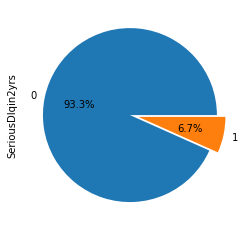

In [5]:
X['SeriousDlqin2yrs'].value_counts().plot.pie(explode=[0,0.1],autopct='%1.1f%%')
plt.show()

____________________________________________________________
**전체 Train 데이터중 약 6.7%만이 2년이내 연체할 가능성이 높은 고객으로 판별되었다**
____________________________________________________________

In [6]:
def MissingHandler(df):
    DataMissing = df.isnull().sum()*100/len(df)
    DataMissingByColumn = pd.DataFrame({'Percentage Nulls':DataMissing})
    DataMissingByColumn.sort_values(by='Percentage Nulls', ascending=False,inplace=True)
    return DataMissingByColumn[DataMissingByColumn['Percentage Nulls']>0]
print(MissingHandler(X))
print(MissingHandler(Y))

                    Percentage Nulls
MonthlyIncome              19.820667
NumberOfDependents          2.616000
                    Percentage Nulls
SeriousDlqin2yrs          100.000000
MonthlyIncome              19.805326
NumberOfDependents          2.587116


____________________________________________________________
**전체 데이터중 'MonthlyIncome'과 'NumberOfDependents' 변수에 결측치가 존재함을 알 수 있다**
____________________________________________________________

### (3)변수간의 상관관계

**확인 결과 Train 데이터와 Test 데이터 모두 유사한 양상을 보이며,**
- 'NumberOfTime30-59DaysPastDueNotWorse ' 'NumberOfTime60-89DaysPastDueNotWorse ', 'NumberOfTimes90DaysLate' : 0.99
- 'NumberOfOpenCreditLinesAndLoans','NumberRealEstateLoansOrLines': 0.43

**의 순으로 높은 상관관계를 보여왔으며, 나머지는 낮은 상관관계를 보이는 것을 확인할 수 있다. 이역시 다중공선성 등의 문제를 일으킬 정도는 아닌 것으로 판단된다.**

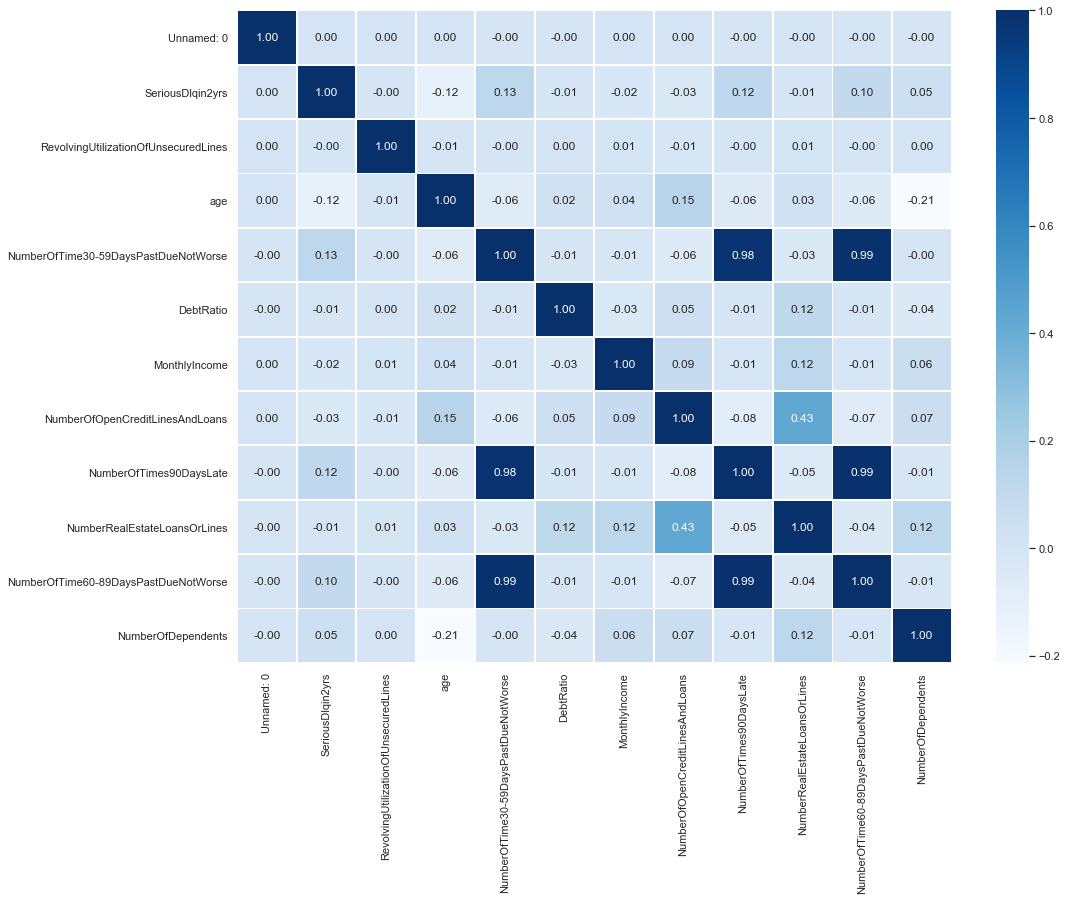

In [7]:
sns.heatmap(data=X.corr(),annot=True,fmt='.2f', linewidths=.8,cmap='Blues')

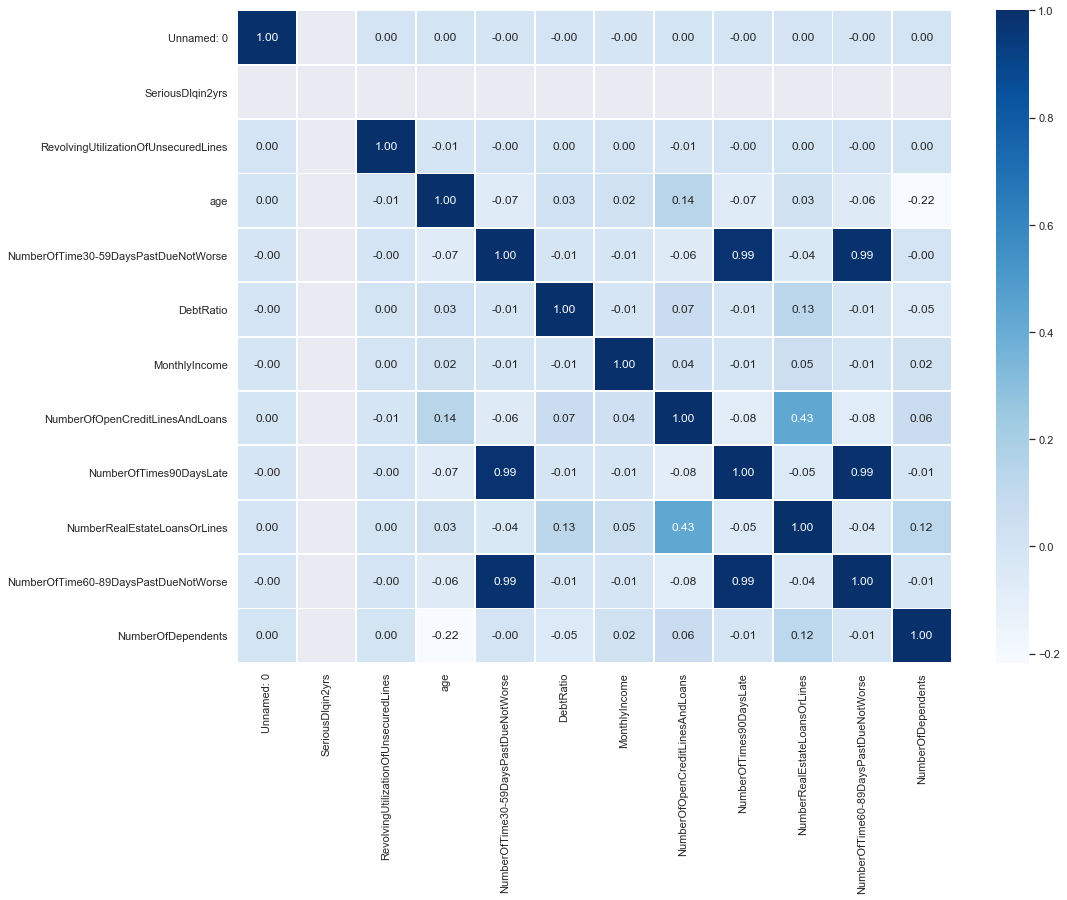

In [9]:
sns.heatmap(data=Y.corr(),annot=True,fmt='.2f', linewidths=.8,cmap='Blues')

### (4) 분포 및 이상치 확인

In [50]:
X.loc[(X['DebtRatio'] > 1000) & (X['MonthlyIncome'] < 1000), 'DebtRatio'].sort_values()

91485      1004.0
48438      1005.0
298        1005.0
139944     1006.0
122462     1007.0
           ...   
63855     25033.0
19361     25801.0
146310    49112.0
127898    60212.0
53682     61106.5
Name: DebtRatio, Length: 1000, dtype: float64

In [63]:
X[X['age'] == 0]

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
65695,65696,0,1.0,0,1,0.436927,6000.0,6,0,2,0,2.0


In [9]:
X.describe()

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,1.202690e+05,150000.000000,150000.000000,150000.000000,150000.000000,146076.000000
mean,75000.500000,0.066840,6.048438,52.295207,0.421033,353.005076,6.670221e+03,8.452760,0.265973,1.018240,0.240387,0.757222
std,43301.414527,0.249746,249.755371,14.771866,4.192781,2037.818523,1.438467e+04,5.145951,4.169304,1.129771,4.155179,1.115086
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,37500.750000,0.000000,0.029867,41.000000,0.000000,0.175074,3.400000e+03,5.000000,0.000000,0.000000,0.000000,0.000000
50%,75000.500000,0.000000,0.154181,52.000000,0.000000,0.366508,5.400000e+03,8.000000,0.000000,1.000000,0.000000,0.000000
75%,112500.250000,0.000000,0.559046,63.000000,0.000000,0.868254,8.249000e+03,11.000000,0.000000,2.000000,0.000000,1.000000
max,150000.000000,1.000000,50708.000000,109.000000,98.000000,329664.000000,3.008750e+06,58.000000,98.000000,54.000000,98.000000,20.000000


In [10]:
Y.describe()

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,101503.000000,0.0,101503.000000,101503.000000,101503.000000,101503.000000,8.140000e+04,101503.000000,101503.000000,101503.000000,101503.000000,98877.000000
mean,50752.000000,NaN,5.310000,52.405436,0.453770,344.475020,6.855036e+03,8.453514,0.296691,1.013074,0.270317,0.769046
std,29301.536524,NaN,196.156039,14.779756,4.538487,1632.595231,3.650860e+04,5.144100,4.515859,1.110253,4.503578,1.136778
min,1.000000,NaN,0.000000,21.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,25376.500000,NaN,0.030131,41.000000,0.000000,0.173423,3.408000e+03,5.000000,0.000000,0.000000,0.000000,0.000000
50%,50752.000000,NaN,0.152586,52.000000,0.000000,0.364260,5.400000e+03,8.000000,0.000000,1.000000,0.000000,0.000000
75%,76127.500000,NaN,0.564225,63.000000,0.000000,0.851619,8.200000e+03,11.000000,0.000000,2.000000,0.000000,1.000000
max,101503.000000,NaN,21821.000000,104.000000,98.000000,268326.000000,7.727000e+06,85.000000,98.000000,37.000000,98.000000,43.000000


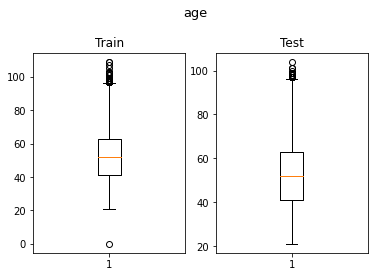

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
65695,65696,0,1.0,0,1,0.436927,6000.0,6,0,2,0,2.0


In [11]:
plt.suptitle('age',fontsize=13)
plt.subplots_adjust(top=0.82)

ax1 = plt.subplot(1,2,1)
plt.boxplot(X['age'])
plt.title("Train")

ax1 = plt.subplot(1,2,2)
plt.boxplot(Y['age'])
plt.title("Test")
plt.show()

X[X['age'] <= 20]

--------------------------------------------------------------------------
**Train 데이터에서 금융상품을 이용할 수 연령층을 벗어난 표본(0세)은 제거하는 것이 합리적일 것으로 판단된다.**

---------------------------------------------------------

In [12]:
X= X.drop([65695])

### (5) RevolvingUtilizationOfUnsecuredLines 변수 분석 및 처리

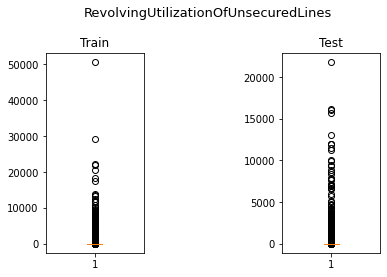

In [13]:
plt.suptitle('RevolvingUtilizationOfUnsecuredLines',fontsize=13)
plt.subplots_adjust(top=0.82)

ax1 = plt.subplot(1,3,1)
plt.boxplot(X['RevolvingUtilizationOfUnsecuredLines'])
plt.title("Train")

ax1 = plt.subplot(1,3,3)
plt.boxplot(Y['RevolvingUtilizationOfUnsecuredLines'])
plt.title("Test")
plt.show()

In [14]:
print(X['RevolvingUtilizationOfUnsecuredLines'].describe())
print(Y['RevolvingUtilizationOfUnsecuredLines'].describe())

count    149999.000000
mean          6.048472
std         249.756203
min           0.000000
25%           0.029867
50%           0.154176
75%           0.559044
max       50708.000000
Name: RevolvingUtilizationOfUnsecuredLines, dtype: float64
count    101503.000000
mean          5.310000
std         196.156039
min           0.000000
25%           0.030131
50%           0.152586
75%           0.564225
max       21821.000000
Name: RevolvingUtilizationOfUnsecuredLines, dtype: float64


In [15]:
X[(X['RevolvingUtilizationOfUnsecuredLines'] > 40000)]

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
85489,85490,0,50708.0,55,0,0.221757,38000.0,7,0,2,0,0.0


In [16]:
X.loc[(X['RevolvingUtilizationOfUnsecuredLines'] > 28000)]

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
31414,31415,0,29110.0,58,0,0.402560,10000.0,7,0,1,0,0.0
85489,85490,0,50708.0,55,0,0.221757,38000.0,7,0,2,0,0.0


In [17]:
X.loc[X['RevolvingUtilizationOfUnsecuredLines'] > 40000, 'RevolvingUtilizationOfUnsecuredLines'] = 29110

### (6) NumberOfTime(N)DaysPastDueNotWorse 변수 분석 및 처리

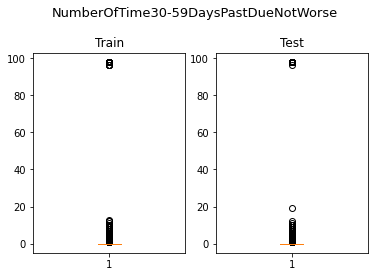

In [18]:
plt.suptitle('NumberOfTime30-59DaysPastDueNotWorse',fontsize=13)
plt.subplots_adjust(top=0.82)

ax1 = plt.subplot(1,2,1)
plt.boxplot(X['NumberOfTime30-59DaysPastDueNotWorse'])
plt.title("Train")

ax2 = plt.subplot(1,2,2)
plt.boxplot(Y['NumberOfTime30-59DaysPastDueNotWorse'])
plt.title("Test")
plt.show()

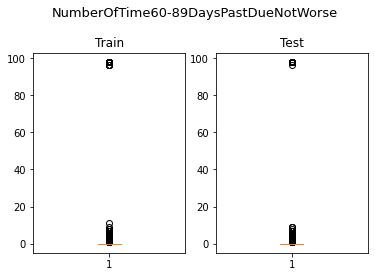

In [19]:
plt.suptitle('NumberOfTime60-89DaysPastDueNotWorse',fontsize=13)
plt.subplots_adjust(top=0.82)

ax2 = plt.subplot(1,2,1)
plt.boxplot(X['NumberOfTime60-89DaysPastDueNotWorse'])
plt.title("Train")

ax2 = plt.subplot(1,2,2)
plt.boxplot(Y['NumberOfTime60-89DaysPastDueNotWorse'])
plt.title("Test")
plt.show()


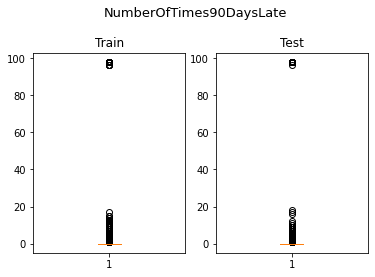

In [20]:
plt.suptitle('NumberOfTimes90DaysLate',fontsize=13)
plt.subplots_adjust(top=0.82)

ax2 = plt.subplot(1,2,1)
plt.boxplot(X['NumberOfTimes90DaysLate'])
plt.title("Train")

ax2 = plt.subplot(1,2,2)
plt.boxplot(Y['NumberOfTimes90DaysLate'])
plt.title("Test")
plt.show()

Text(0.5, 0, '90- days')

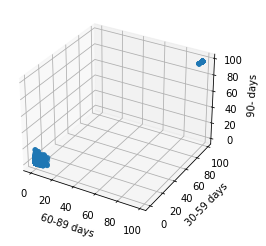

In [21]:
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.scatter(X['NumberOfTime60-89DaysPastDueNotWorse'], X['NumberOfTime30-59DaysPastDueNotWorse'],X['NumberOfTimes90DaysLate'])
ax.set_xlabel('60-89 days')
ax.set_ylabel('30-59 days')
ax.set_zlabel('90- days')

Text(0.5, 0, '90- days')

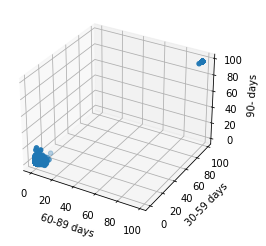

In [22]:
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.scatter(Y['NumberOfTime60-89DaysPastDueNotWorse'], Y['NumberOfTime30-59DaysPastDueNotWorse'],Y['NumberOfTimes90DaysLate'])
ax.set_xlabel('60-89 days')
ax.set_ylabel('30-59 days')
ax.set_zlabel('90- days')

------------------------------------------------------------------
NumberOfTime(N)DaysPastDueNotWorse 변수에서 이상치를 가진 고객들은 모두 일수(30-59일, 60-89일, 90일 이상)에 관계없이 모든 종류의 일수에서 100근처의 이상치를 가지고 있음을 확인할 수 있다. 이는 Test와 Train 데이터 모두에서 나타나고 있다. 

-------------------------------------------------------------------

In [23]:
Day_train = X[['NumberOfTime30-59DaysPastDueNotWorse','NumberOfTime60-89DaysPastDueNotWorse','NumberOfTimes90DaysLate']]
Day_test=Y[['NumberOfTime30-59DaysPastDueNotWorse','NumberOfTime60-89DaysPastDueNotWorse','NumberOfTimes90DaysLate']]

In [24]:
X[(Day_train['NumberOfTimes90DaysLate'] < 50)].describe()

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,149730.000000,149730.000000,149730.000000,149730.000000,149730.000000,149730.000000,1.201200e+05,149730.000000,149730.000000,149730.000000,149730.000000,145837.000000
mean,75002.264636,0.065979,5.913295,52.327984,0.245789,353.631316,6.675295e+03,8.467949,0.090456,1.020063,0.064823,0.757846
std,43302.296135,0.248246,225.783924,14.754371,0.697779,2039.601344,1.439255e+04,5.138107,0.485529,1.129961,0.330074,1.115382
min,1.000000,0.000000,0.000000,21.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,37501.250000,0.000000,0.029771,41.000000,0.000000,0.175994,3.400000e+03,5.000000,0.000000,0.000000,0.000000,0.000000
50%,75005.500000,0.000000,0.153488,52.000000,0.000000,0.367119,5.400000e+03,8.000000,0.000000,1.000000,0.000000,0.000000
75%,112502.750000,0.000000,0.555592,63.000000,0.000000,0.870023,8.250000e+03,11.000000,0.000000,2.000000,0.000000,1.000000
max,150000.000000,1.000000,29110.000000,109.000000,13.000000,329664.000000,3.008750e+06,58.000000,17.000000,54.000000,11.000000,20.000000


In [25]:
X[(Day_train['NumberOfTimes90DaysLate'] > 50)].describe()

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,269.000000,269.000000,2.690000e+02,269.000000,269.000000,269.000000,148.000000,269.000000,269.000000,269.0,269.000000,238.000000
mean,74052.862454,0.546468,9.999999e-01,34.245353,97.962825,5.739667,2557.135135,0.007435,97.962825,0.0,97.962825,0.369748
std,42954.890845,0.498764,2.891960e-15,13.061823,0.270628,26.019024,2745.777653,0.086065,0.270628,0.0,0.270628,0.830490
min,1734.000000,0.000000,9.999999e-01,21.000000,96.000000,0.000000,0.000000,0.000000,96.000000,0.0,96.000000,0.000000
25%,37025.000000,0.000000,9.999999e-01,24.000000,98.000000,0.000000,1333.000000,0.000000,98.000000,0.0,98.000000,0.000000
50%,72518.000000,1.000000,9.999999e-01,29.000000,98.000000,0.000000,2168.500000,0.000000,98.000000,0.0,98.000000,0.000000
75%,109885.000000,1.000000,9.999999e-01,43.000000,98.000000,0.000000,3174.500000,0.000000,98.000000,0.0,98.000000,0.000000
max,149770.000000,1.000000,9.999999e-01,79.000000,98.000000,255.000000,28733.000000,1.000000,98.000000,0.0,98.000000,5.000000


AxesSubplot(0.260833,0.125;0.503333x0.755)


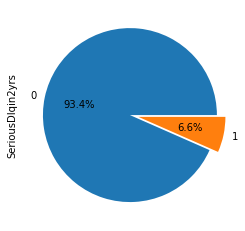

In [26]:
print(X[(Day_train['NumberOfTimes90DaysLate'] < 50)]['SeriousDlqin2yrs'].value_counts().plot.pie(explode=[0,0.1],autopct='%1.1f%%'))

AxesSubplot(0.260833,0.125;0.503333x0.755)


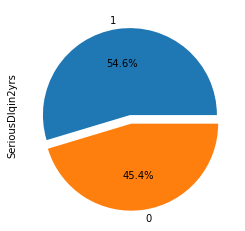

In [27]:
print(X[(Day_train['NumberOfTimes90DaysLate'] > 50)]['SeriousDlqin2yrs'].value_counts().plot.pie(explode=[0,0.1],autopct='%1.1f%%'))

------------------------------------------------------------------
NumberOfTime(N)DaysPastDueNotWorse 변수에서 이상치를 가진 고객들을 이상치를 가지지 않은 고객집단과 비교할 시, 2년 이내 파산할 확률 변수('SriosDIain2yrs')에서 유의미한 차이를 보고 있다.결과적으로, 이상치들을 가진 고객들을 그룹으로 볼때, 그룹내에서 차이가 뚜렷함을 확인할 수 있다. 

-------------------------------------------------------------------

AxesSubplot(0.260833,0.125;0.503333x0.755)


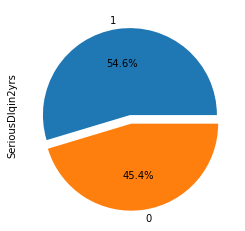

In [28]:
print(X[(Day_train['NumberOfTimes90DaysLate'] > 50)&(Day_train['NumberOfTimes90DaysLate'] > 10)]['SeriousDlqin2yrs'].value_counts().plot.pie(explode=[0,0.1],autopct='%1.1f%%'))

------------------------------------------------------------------
NumberOfTime(N)DaysPastDueNotWorse 변수에서 이상치가 아닌 고객 집단중 NumberOfTime90DaysLate 변수에서 10이상의 가진 고객집단과 비교할 시, 2년 이내 파산할 확률 변수('SriosDIain2yrs')에서 유사한 모습을 보여주고 있다. 

-------------------------------------------------------------------

In [29]:
X[(X['NumberOfTimes90DaysLate'] < 50)][['NumberOfOpenCreditLinesAndLoans','NumberRealEstateLoansOrLines']].describe()

,NumberOfOpenCreditLinesAndLoans,NumberRealEstateLoansOrLines
count,149730.000000,149730.000000
mean,8.467949,1.020063
std,5.138107,1.129961
min,0.000000,0.000000
25%,5.000000,0.000000
50%,8.000000,1.000000
75%,11.000000,2.000000
max,58.000000,54.000000


In [30]:
X[(X['NumberOfTimes90DaysLate'] > 50)][['NumberOfOpenCreditLinesAndLoans','NumberRealEstateLoansOrLines']].describe()

,NumberOfOpenCreditLinesAndLoans,NumberRealEstateLoansOrLines
count,269.000000,269.0
mean,0.007435,0.0
std,0.086065,0.0
min,0.000000,0.0
25%,0.000000,0.0
50%,0.000000,0.0
75%,0.000000,0.0
max,1.000000,0.0


------------------------------------------------------------------
NumberOfTime(N)DaysPastDueNotWorse 변수에서 이상치를 가진 고객들을 이상치를 가지지 않은 고객집단과 비교할 시, 'NumberOfOpenCreditLinesAndLoans'와 'NumberRealEstateLoansOrLines' 변수에서 평균이 0에 가까운 특징을 보이고 있다.
다만, 이는 좀 더 추가적인 분석 및 자료조사가 필요할 것으로 보인다.

-------------------------------------------------------------------

In [31]:
X.loc[X['NumberOfTime30-59DaysPastDueNotWorse'] >= 50, 'NumberOfTime30-59DaysPastDueNotWorse'] = 13
X.loc[X['NumberOfTime60-89DaysPastDueNotWorse'] >= 50, 'NumberOfTime60-89DaysPastDueNotWorse'] = 11
X.loc[X['NumberOfTimes90DaysLate'] >= 50, 'NumberOfTimes90DaysLate'] = 17

In [32]:
Y.loc[Y['NumberOfTime30-59DaysPastDueNotWorse'] >= 50, 'NumberOfTime30-59DaysPastDueNotWorse'] = 13
Y.loc[Y['NumberOfTime60-89DaysPastDueNotWorse'] >= 50, 'NumberOfTime60-89DaysPastDueNotWorse'] = 11
Y.loc[Y['NumberOfTimes90DaysLate'] >= 50, 'NumberOfTimes90DaysLate'] = 17

### (7) NumberOfDependents 분석 및 처리
- Train, Test 데이터 모두 약 2~3% 정도의 결측치를 보유하고 있다

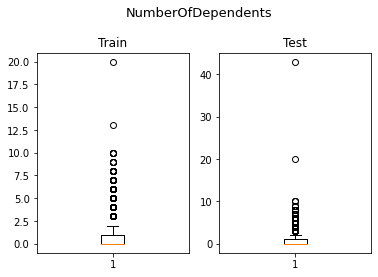

In [33]:
plt.suptitle('NumberOfDependents',fontsize=13)
plt.subplots_adjust(top=0.82)

ax1 = plt.subplot(1,2,1)
plt.boxplot(X['NumberOfDependents'].dropna())
plt.title("Train")

ax2 = plt.subplot(1,2,2)
plt.boxplot(Y['NumberOfDependents'].dropna())
plt.title("Test")
plt.show()

In [34]:
X['NumberOfDependents'].describe()

count    146075.000000
mean          0.757214
std           1.115085
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max          20.000000
Name: NumberOfDependents, dtype: float64

In [35]:
X[(X['NumberOfDependents'] > 10)]['NumberOfDependents'].describe()

count     2.000000
mean     16.500000
std       4.949747
min      13.000000
25%      14.750000
50%      16.500000
75%      18.250000
max      20.000000
Name: NumberOfDependents, dtype: float64

AxesSubplot(0.260833,0.125;0.503333x0.755)


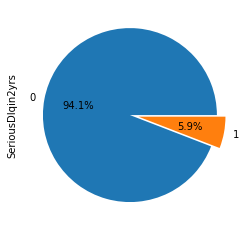

In [36]:
print(X[(X['NumberOfDependents'] == 0)]['SeriousDlqin2yrs'].value_counts().plot.pie(explode=[0,0.1],autopct='%1.1f%%'))

AxesSubplot(0.260833,0.125;0.503333x0.755)


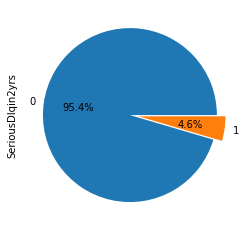

In [37]:
print(X[X['NumberOfDependents'].isnull() == True]['SeriousDlqin2yrs'].value_counts().plot.pie(explode=[0,0.1],autopct='%1.1f%%'))

In [38]:
X[X['NumberOfDependents'].isnull() == True]

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
8,9,0,0.116951,27,0,46.0,NaN,2,0,0,0,NaN
96,97,0,0.542243,48,2,10.0,NaN,2,0,0,0,NaN
109,110,0,0.041258,61,0,4739.0,NaN,11,0,4,0,NaN
159,160,0,0.000000,63,0,2.0,NaN,4,0,0,0,NaN
238,239,0,1.000000,28,0,0.0,NaN,0,0,0,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
149826,149827,0,0.027319,71,0,1419.0,NaN,13,0,1,0,NaN
149854,149855,0,0.056589,75,0,8.0,NaN,3,0,0,0,NaN
149894,149895,0,0.017904,55,0,1058.0,NaN,8,0,1,1,NaN
149948,149949,0,0.055530,27,0,10.0,NaN,1,0,0,0,NaN


In [39]:
X[X['NumberOfDependents'].isnull() == True]['MonthlyIncome'].describe()

count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: MonthlyIncome, dtype: float64

In [40]:
Y[Y['NumberOfDependents'].isnull() == True]['MonthlyIncome'].describe()

count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: MonthlyIncome, dtype: float64

______________________________________________________________________________
특이한 점은, NumberOfDependents 변수가 결측치인 경우, MonthlyIncome 변수 역시 모두 결측치라는 점이다. 이는 은행이 고객정보 기재시, 공통적으로 데이터를 기재하지 않았을 확률이 높아 보인다. 이럴 경우, 현재 NumberOfDependents의 변수에서 과반을 차지하고 있는 최빈값 0을 부여하는 것이 적절해보인다.

(참고. NumberOfDependets 변수 결측치 비율은 3% 내외, MonthlyIncome 변수 결측치 비율은 20% 내외)
______________________________________________________________________________

In [41]:
X.loc[X['NumberOfDependents'].isnull() == True, 'NumberOfDependents'] = 0
Y.loc[Y['NumberOfDependents'].isnull() == True, 'NumberOfDependents'] = 0

### (8) MonthlyIncome 변수 분석 및 처리

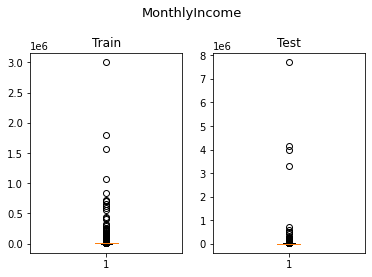

In [42]:
plt.suptitle('MonthlyIncome',fontsize=13)
plt.subplots_adjust(top=0.82)

ax1 = plt.subplot(1,2,1)
plt.boxplot(X['MonthlyIncome'].dropna())
plt.title("Train")

ax2 = plt.subplot(1,2,2)
plt.boxplot(Y['MonthlyIncome'].dropna())
plt.title("Test")
plt.show()

In [43]:
X['MonthlyIncome'].describe()

count    1.202680e+05
mean     6.670227e+03
std      1.438473e+04
min      0.000000e+00
25%      3.400000e+03
50%      5.400000e+03
75%      8.249000e+03
max      3.008750e+06
Name: MonthlyIncome, dtype: float64

In [44]:
X['MonthlyIncome'].fillna(X['MonthlyIncome'].median(), inplace=True)
Y['MonthlyIncome'].fillna(Y['MonthlyIncome'].median(), inplace=True)

### (9) 나머지 변수 확인

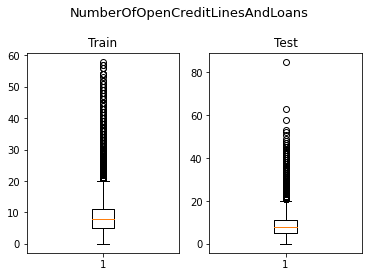

In [45]:
plt.suptitle('NumberOfOpenCreditLinesAndLoans',fontsize=13)
plt.subplots_adjust(top=0.82)

ax1 = plt.subplot(1,2,1)
plt.boxplot(X['NumberOfOpenCreditLinesAndLoans'])
plt.title("Train")

ax1 = plt.subplot(1,2,2)
plt.boxplot(Y['NumberOfOpenCreditLinesAndLoans'])
plt.title("Test")
plt.show()

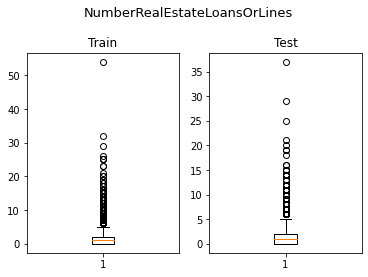

In [46]:
plt.suptitle('NumberRealEstateLoansOrLines',fontsize=13)
plt.subplots_adjust(top=0.82)

ax1 = plt.subplot(1,2,1)
plt.boxplot(X['NumberRealEstateLoansOrLines'])
plt.title("Train")

ax1 = plt.subplot(1,2,2)
plt.boxplot(Y['NumberRealEstateLoansOrLines'])
plt.title("Test")
plt.show()

_______________________________________________________________________
나머지 변수들은 정상적인 범주내에서 존재하는 수치로 판단하여 이상치로 판단하지 않았다

-----------------------------------------------------------------

##### [추후 변수 추가 예정]

### III. 모델링


분류에 적용하기위해 적합한 알고리즘들을 취사선택하여 적용해보았습니다.
- 독립변수와 종속변수의 선형 관계성에 기반한 로지스틱 회귀
- 데이터 균일도에 따른 규칙 기반의 결정트리
- 개별 클래스 간의 분류 마진을 효과적으로 찾아주는 서포트 벡터 머신(단, 커널같은 적절한 전처리 필요)
- 근접 거리를 기준으로 하는 최소 근접 알고리즘
- 서로 다른 머신러닝 알고리즘을 결합한 앙상블


### (0) 진행을 위한 준비

#### GridCV를 활용한 최적의 파라메터를 탐색하기 위해 Train 데이터 내에서 Train 데이터와 Test 데이터로 나눠준다

In [47]:
from sklearn.naive_bayes import GaussianNB 
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm 
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.model_selection import train_test_split 
from sklearn import metrics 
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score

In [48]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold #for K-fold cross validation
from sklearn.model_selection import cross_val_score #score evaluation
from sklearn.model_selection import cross_val_predict #prediction

In [49]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split

In [50]:
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')

In [51]:
X = X.drop(['Unnamed: 0'], axis=1)
Y = Y.drop(['Unnamed: 0'], axis=1)

In [66]:
Y = Y.drop(['SeriousDlqin2yrs'], axis=1)

In [52]:
X_target = X.drop('SeriousDlqin2yrs', axis=1)
X_features = X['SeriousDlqin2yrs']

In [53]:
train_X, test_X, train_Y, test_Y = train_test_split( X_target,X_features, test_size=0.3 , random_state=0)

In [54]:
pd.DataFrame(train_X).info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 104999 entries, 120043 to 43567
Data columns (total 10 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   RevolvingUtilizationOfUnsecuredLines  104999 non-null  float64
 1   age                                   104999 non-null  int64  
 2   NumberOfTime30-59DaysPastDueNotWorse  104999 non-null  int64  
 3   DebtRatio                             104999 non-null  float64
 4   MonthlyIncome                         104999 non-null  float64
 5   NumberOfOpenCreditLinesAndLoans       104999 non-null  int64  
 6   NumberOfTimes90DaysLate               104999 non-null  int64  
 7   NumberRealEstateLoansOrLines          104999 non-null  int64  
 8   NumberOfTime60-89DaysPastDueNotWorse  104999 non-null  int64  
 9   NumberOfDependents                    104999 non-null  float64
dtypes: float64(4), int64(6)
memory usage: 8.8 MB


### (1) 모델 시범 적용


#### 가우시안 나이브 베이즈
- 나이브 베이즈 모델은 베이지안 개념을 적용시켜 데이터 셋의 독립성을 기반으로 학습하는 계산 방법이다. 훈련과 예측 속도가 빠르며 훈련 과정을 이해하기 쉽다. 희소한 고차원 데이터에서 잘 작동하며 비교적 매개변수에 민감하지 않다. 특히, GaussianNB는 대부분 매우 고차원인 데이터셋에 사용하며, 타 나이브 베이즈 모델은 텍스트 같은 희소한 데이터를 카운트하는 데 사용한다.

In [312]:
# Gaussian Naive Bayes
model=GaussianNB()
model.fit(train_X,train_Y)
prediction1=model.predict(test_X)
print('The roc_auc_score of the NaiveBayes is',metrics.roc_auc_score(prediction1,test_Y))

The roc_auc_score of the NaiveBayes is 0.7072229941610445


In [ ]:
# Radial Support Vector Machines(rbf-SVM)
model=svm.SVC(kernel='rbf',C=1,gamma=0.1)
model.fit(train_X,train_Y)

prediction4=model.predict(test_X)
print('The roc_auc_score of the rbf-SVM is',metrics.roc_auc_score(prediction4,test_Y))

#### 로지스틱 회귀
- 선형회귀 방식이 가지고 있는 약점을 극복하기 위해 커널을 적용한 알고리즘입니다. 선형함수의 회귀 최적선을 찾는 선형회귀와 달리 **로지스틱 회귀는 학습을 통해 시그모이드(Sigmoid)함수 최적선을 찾고, 이 시그모이드 함수의 반환 값을 확률로 간주해 확률에 따라 분류를 결정하는 방식이다.**

In [314]:
# Logistic Regression
model = LogisticRegression()
model.fit(train_X,train_Y)
prediction2=model.predict(test_X)
print('The roc_auc_score of the Logistic Regression is',metrics.roc_auc_score(prediction2,test_Y))

The roc_auc_score of the Logistic Regression is 0.7584463914130543


#### 의사결정나무
- 의사결정나무는 의사결정 규칙을 나무 구조로 나타내어 전체 자료를 몇 개의 소집단으로 분류하거나 예측을 수행하는 분석방법이다. 이때 몇 개의 소집단(노드)로 분류될 때, 이 때 소집단내에선 동질성이 커지고, 소집단간에는 이질성이 가장 커지도록 선택된다. **이때, 카이제곱통계량  P값과 지니지수 가 모두 작아지는 방향으로 분류를 진행한다.**
- 단점으로는 학습하는 데이터마다 구조가 크게 달라지고 trial & error 방식으로 학습하므로 계산 비용 또한 크다. 데이터 전처리 방법으로 주로 사용된다.

In [57]:
#Decison Tree
dt_clf=DecisionTreeClassifier(random_state=0)
dt_clf.fit(train_X,train_Y)
prediction2=dt_clf.predict(test_X)
print('The roc_auc_score of the Logistic Regression is',metrics.roc_auc_score(prediction2,test_Y))

The roc_auc_score of the Logistic Regression is 0.5948518296388108


#### 배깅 방법
동일한 알고리즘(ex.의사결정나무)로 여러 개의 분류기를 만들어서 투표를 통해 최종 결정하는 알고리즘이다. 분류기들에 가중치를 주어 선형결합을 통해 최종 결과를 예측하는 방법에 해당한다. 쉽게 말해 기본적인 의사결정나무와는 달리 부트스트랩  방식을 통해 전체데이터에서 중복을 허용하여 n개의 데이터를 추출하고, 또한 피처값 중에서 중복 허용 없이 k개를 추출하여 만든 데이터를 바탕으로 분류기에 넣어 데이터를 예측한다. 이러한 과정을 여러 번 반복하여 여러 개의 분류기에서 나온 결과값을 바탕으로 예측을 진행한다.(간단하게 여러 개가 학습하면 더 현명하게 학습할 거라고 기대하고 만드는 모델. 그러나 이 방법도 정확도만 높아지고 분산에 대해선 보장을 못하는 단점이 있다.)

- RandomForest Classifier

In [57]:
#RandomForest Classifier
dt_rf = RandomForestClassifier(random_state=0)
dt_rf.fit(train_X,train_Y)
prediction2=dt_rf.predict(test_X)
print('The roc_auc_score of the RandomForest Classifier is',metrics.roc_auc_score(prediction2,test_Y))

The roc_auc_score of the RandomForest Classifier is 0.7385069785495897


#### 부스팅 방법
부스팅 알고리즘은 분포에 대해 약한 학습자를 반복적으로 학습시켜 최종적으로 강한 학습자를 만드는 것을 목표로한다. 강한 학습자를 만들기 위해 약한 학습자들의 잔차가 큰 잘못 예측한 데이터에 대해 가중치를 부여하여 예측성을 향상시키고자 한다. 

- XGBClassifier
- LightGBM

In [60]:
#XGBClassifier
xgb_wrapper = XGBClassifier()
xgb_wrapper.fit(train_X,train_Y)
prediction2=xgb_wrapper.predict(test_X)
print('The roc_auc_score of the XGBClassifier is', metrics.roc_auc_score(prediction2,test_Y))

The roc_auc_score of the XGBClassifier is 0.7441114404831323


참고)
LightGBM은 XG부스트의 개선 분류모델에 해당한다. XG부스트는 부스팅 모델중에서 상대적으로 빠르긴하나, 여전히 시간이 오래 걸린다는 문제점을 가지고 있습니다. 예측성을 유지하면서도 이러한 문제를 해결한 알고리즘이 LightGBM이다. LightGBM은 대용량 데이터 처리에 적합하며, 메모리 사용량도 적으며, CPU뿐만 아니라 GPU도 활용가능하다. 다만, 너무 적은 양의 데이터에 사용시 과적합 문제가 발생할 가능성이 높다

In [62]:
lgb_wrapper = LGBMClassifier()
lgb_wrapper.fit(train_X,train_Y)
prediction2=lgb_wrapper.predict(test_X)
print('The roc_auc_score of the LGBMClassifier is', metrics.roc_auc_score(prediction2,test_Y))

The roc_auc_score of the LGBMClassifier is 0.7616870702921765


- 이 중 기본 파라메터로 비교적 높은 예측력을 보인, 의사결정나무와 로지스틱 회귀 파라메터 튜닝을 진행하였다

### (2) 모델 파라메터 튜닝

#### 1) 로지스틱 회귀 모델 튜닝

In [63]:
params2={'penalty':['l1','l2'],
        'C':[0.1,0.3,0.5,0.7,0.9]}
model = LogisticRegression()
grid_cv2=GridSearchCV(model,param_grid=params2,scoring='roc_auc',cv=5)
grid_cv2.fit(train_X,train_Y)
print('GridSearchCV 최고 평균 roc_auc 점수:',grid_cv2.best_score_)
print('GridSearchCV 최적 하이퍼 파라미터:',grid_cv2.best_params_)

GridSearchCV 최고 평균 roc_auc 점수: 0.7719723814915952
GridSearchCV 최적 하이퍼 파라미터: {'C': 0.9, 'penalty': 'l2'}


In [69]:
model = LogisticRegression(C=0.9, penalty='l2')
model.fit(X_target,X_features)

pred_probs=pd.DataFrame(model.predict_proba(Y))[1]
lr_wrapper_pred=pd.DataFrame(pred_probs)
lr_wrapper_pred.index += 1 
lr_wrapper_pred.to_csv(r"제출-로지스틱회귀#1.csv", index=True)

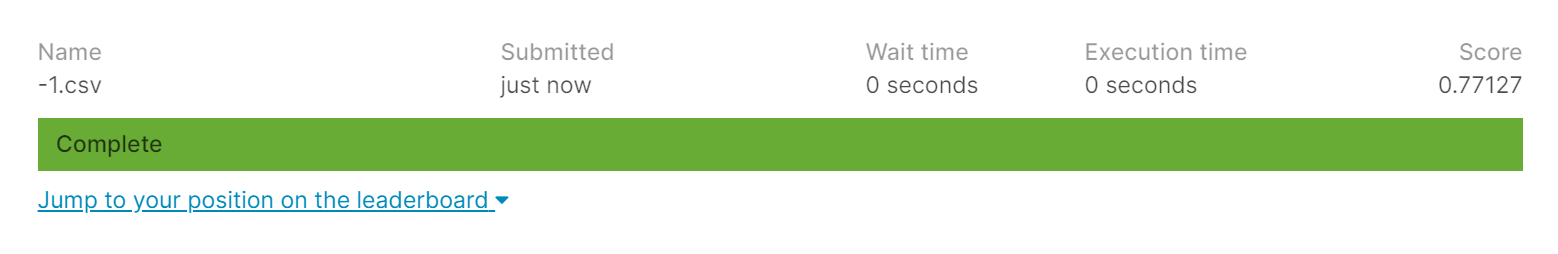

#### 2) 랜덤포레스트 모델 튜닝

In [65]:
params={
    'max_depth':[1,3,5,10],
    'min_samples_leaf':[1,3,5,10],
    'min_samples_split':[1,3,5,10]
    }
#RandomForest를 설정하고 GridSearchCV수행
rf_clf=RandomForestClassifier(random_state=0,n_jobs=-1)
grid_cv = GridSearchCV(rf_clf, param_grid=params,cv=3,n_jobs=-1,scoring='roc_auc')
grid_cv.fit(train_X,train_Y)
cv_result=pd.DataFrame(grid_cv.cv_results_)

print('최적 하이퍼 파라미터와 예측 roc_auc 점수:',grid_cv.best_params_,grid_cv.best_score_)

최적 하이퍼 파라미터와 예측 roc_auc 점수: {'max_depth': 10, 'min_samples_leaf': 10, 'min_samples_split': 3} 0.8629319817935418


In [61]:
rf_clf = RandomForestClassifier(random_state=0, n_jobs=-1, max_depth=20, min_samples_leaf=10, min_samples_split=3)
rf_clf.fit(train_X,train_Y)
prediction2=rf_clf.predict(test_X)

print('The roc_auc_score of the RandomForestClassifier is', metrics.roc_auc_score(prediction2,test_Y))

The roc_auc_score of the RandomForestClassifier is 0.769101348502687


In [70]:
model =  RandomForestClassifier(random_state=0, n_jobs=-1, max_depth=20, min_samples_leaf=10, min_samples_split=3)
model.fit(X_target,X_features)

pred_probs=pd.DataFrame(model.predict_proba(Y))[1]
lr_wrapper_pred=pd.DataFrame(pred_probs)
lr_wrapper_pred.index += 1 
lr_wrapper_pred.to_csv(r"제출-랜덤포레스트#1.csv", index=True)

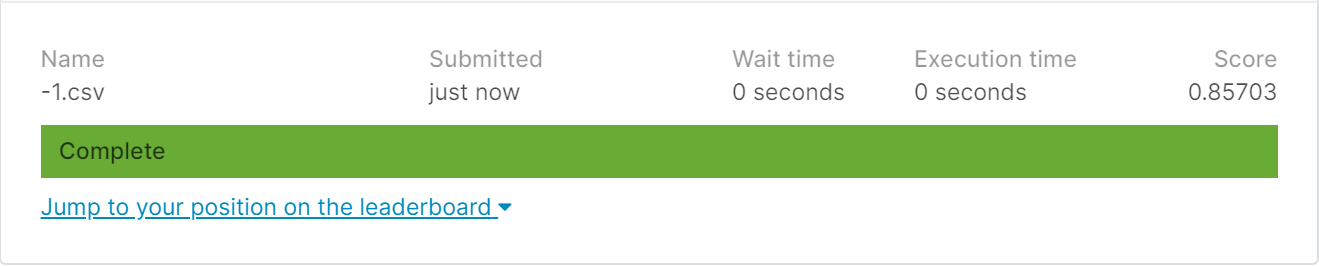

#### 3)XGBoost 모델 튜닝

In [72]:
params={
    'max_depth':[1,5,10,15],
    'learning_rate':[0.1, 0.5, 1.0],
    'n_estimators':[1,5,10,100],
    }

xgb_wrapper = XGBClassifier()
grid_cv = GridSearchCV(xgb_wrapper, param_grid=params,cv=5,n_jobs=-1,scoring='roc_auc')
grid_cv.fit(train_X,train_Y)

cv_result=pd.DataFrame(grid_cv.cv_results_)

print('최적 하이퍼 파라미터와 예측 roc_auc 점수:',grid_cv.best_params_,grid_cv.best_score_)

최적 하이퍼 파라미터와 예측 roc_auc 점수: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100} 0.8635525620849236


#### 4) LightGBM 튜닝

In [ ]:
params={
    'max_depth':[1,3,5,10],
    'learning_rate':[0.5,1,3,5,10],
    'n_estimators':[1,3,5,10],
    }

LGBM_wrapper = LGBMClassifier()
grid_cv = GridSearchCV(LGBM_wrapper, param_grid=params,cv=5,n_jobs=-1,scoring='roc_auc')
grid_cv.fit(train_X,train_Y)

cv_result=pd.DataFrame(grid_cv.cv_results_)

print('최적 하이퍼 파라미터와 예측 roc_auc 점수:',grid_cv.best_params_,grid_cv.best_score_)

알게된 점

- 머신러닝 알고리즘의 경우 피처엔지니어링 만으로도 큰 차이를 보일 수 있다. 지속적인 고민이 필요하다

### (3) SMOTE를 활용한 모델 불균형 해결 

현재 데이터에서 고객의 2년내 파산은 3%내외로 극소수에 해당한다. 이는 데이터에 불균형을 초래하며, 데이터의 정확도는 높아도 재현율은이 급격하게 작아지는 현상이 발생할 수 있다. 또한, 이를 통해 얻은 정확성이 높다 하더라도, 신뢰도는 낮을 수 밖에 없다. 이를 해결하고자, 'SMOTE'기법을 활용하여 문제를 수정해보고자 한다. 

In [73]:
from sklearn.datasets import make_classification
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE

In [76]:
sm = SMOTE( ratio='auto', kind='regular' )

# train데이터를 넣어 복제함
X_resampled, y_resampled = sm.fit_sample(train_X,train_Y)

print('After OverSampling, the shape of train_X: {}'.format(X_resampled.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(X_resampled.shape))

print("After OverSampling, counts of label '1': {}".format(sum(y_resampled==1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_resampled==0)))

TypeError: __init__() got an unexpected keyword argument 'ratio'